## On entraîne le modèle sur tous les angles lumière/caméra


In [1]:
from keras.layers import Conv1D, Conv2D, Input, Flatten, Dense, MaxPooling1D, MaxPooling2D, BatchNormalization, Concatenate
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras import layers
import matplotlib.pyplot as plt
from keras.models import Model
import tensorflow as tf
from PIL import Image
import copy
import numpy as np
import keras
import os
import re



# Importation des images

In [2]:
# Dossier contenant les images
repertoire = "../Bonn_Dataset"
img_width, img_height = 50, 50

# Expression pour extraire les infos du nom de fichier
pattern = re.compile(r"(\d+)\s+tl([\d.-]+)\s+pl([\d.-]+)\s+tv([\d.-]+)\s+pv([\d.-]+)\.jpg")

# Stockage des résultats
images_info = []

for root, dirs, files in os.walk(repertoire):
    print(f"Entering directory: {root}") # Affiche le dossier actuel parcouru
    for nom_fichier in files:
        # Assurez-vous que le fichier est bien une image JPG et correspond au pattern
        if nom_fichier.endswith(".jpg"):
            match = pattern.match(nom_fichier)
            if match:
                i, tl, pl, tv, pv = match.groups()
                tl, pl = int(tl), int(pl)
                tv, pv = int(tv), int(pv)
                chemin_image = os.path.join(root, nom_fichier)
                image = Image.open(chemin_image)
                w, h = image.size
                left = (w - img_width) / 2
                top = (h - img_height) / 2
                right = (w + img_width) / 2
                bottom = (h + img_height) / 2
                image = Image.open(chemin_image).crop((left, top, right, bottom))
                pixels = np.array(image, dtype=np.float32) / 255.0

                images_info.append({
                    "tl": tl,
                    "pl": pl,
                    "tv": tv,
                    "pv": pv,
                    "image": image,
                    "pixels": pixels,
                })
            else:
                print(f"Nom de fichier ignoré : {nom_fichier}")

# Exemple : affichage d'une info
for info in images_info[:5]:  # juste les 5 premières
    print(f"tl={info['tl']}, pl={info['pl']}, tv={info['tv']}, pv={info['pv']}")
print("\nProcessing complete. Total images found and processed:", len(images_info))

Entering directory: ../Bonn_Dataset
Entering directory: ../Bonn_Dataset/tv030_pv210
Entering directory: ../Bonn_Dataset/tv075_pv210
Entering directory: ../Bonn_Dataset/tv015_pv120
Entering directory: ../Bonn_Dataset/tv015_pv180
Entering directory: ../Bonn_Dataset/tv075_pv015
Entering directory: ../Bonn_Dataset/tv045_pv100
Entering directory: ../Bonn_Dataset/tv060_pv252
Entering directory: ../Bonn_Dataset/tv075_pv330
Entering directory: ../Bonn_Dataset/tv030_pv330
Entering directory: ../Bonn_Dataset/tv015_pv000
Entering directory: ../Bonn_Dataset/tv075_pv105
Entering directory: ../Bonn_Dataset/tv045_pv240
Entering directory: ../Bonn_Dataset/tv060_pv342
Entering directory: ../Bonn_Dataset/tv045_pv020
Entering directory: ../Bonn_Dataset/tv075_pv135
Entering directory: ../Bonn_Dataset/tv075_pv300
Entering directory: ../Bonn_Dataset/tv030_pv300
Entering directory: ../Bonn_Dataset/tv075_pv195
Entering directory: ../Bonn_Dataset/tv045_pv080
Entering directory: ../Bonn_Dataset/tv075_pv150
Ente

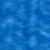

In [3]:
images_info[4000]['image']

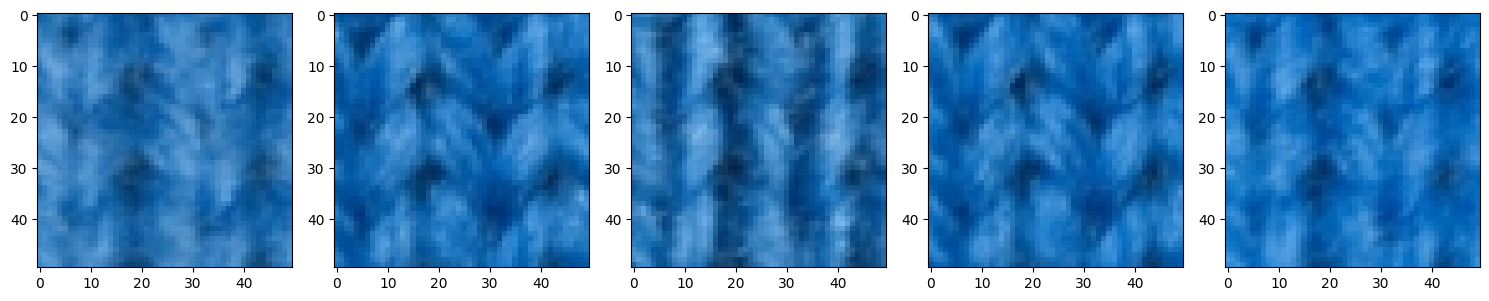

In [4]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5): axes[i].imshow(images_info[i]['pixels'])
plt.tight_layout()
plt.show()

# On trie la liste

In [5]:
sorted = copy.deepcopy(images_info)
sorted.sort(key=lambda d: (d["tv"], d["pv"], d["tl"], d["pl"]))

In [6]:
for i in range(5): print(sorted[i]['pv'])

0
0
0
0
0


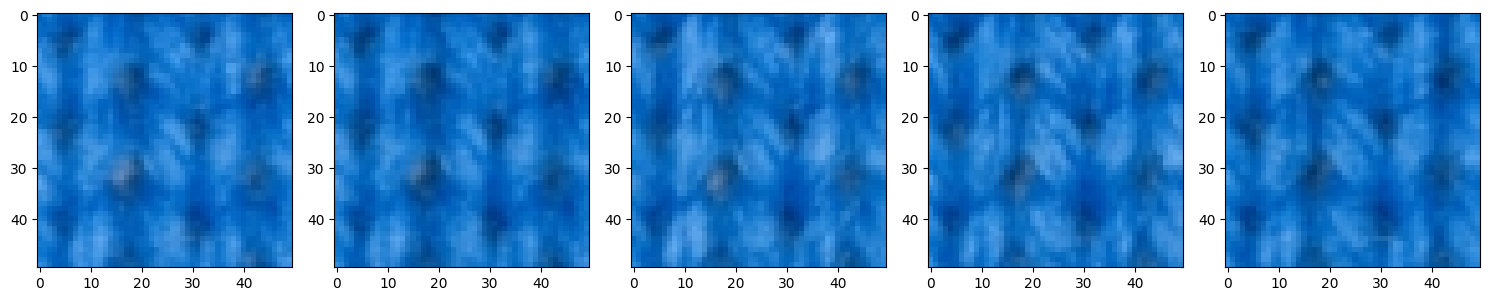

In [7]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5): axes[i].imshow(sorted[i]['pixels'])
plt.tight_layout()
plt.show()

In [8]:
# On trie par les directions de vue, puis de lumière
images_info.sort(key=lambda d: (d["tv"], d["pv"], d["tl"], d["pl"]))

In [9]:
print("Premier pixel de la troisième image (R,G,B) :", images_info[2]['pixels'][0][0])
print("Nombre d'images importées:", len(images_info))

Premier pixel de la troisième image (R,G,B) : [0.         0.38431373 0.7411765 ]
Nombre d'images importées: 6561


# Création du modèles

In [10]:
latent_dim = 8 # Dimension du bottleneck
num_channels = 3 # RGB
samples = len(images_info) # Nombre de configuration angulaires
matrix_H = 9
matrix_W = 9

input_shape = (samples, num_channels)

# Definition
i = Input(shape=input_shape, name='encoder_input')

# Bloc 1
x = Conv1D(filters = 64, kernel_size=3, padding='same', activation='relu')(i)
x = BatchNormalization()(x) #weight decay
x = MaxPooling1D(pool_size=2)(x)

# Bloc 2
x = Conv1D(filters = 128, kernel_size=3, padding='same', activation='relu')(i)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

# Bloc 3
x = Conv1D(filters = 256, kernel_size=3, padding='same', activation='relu')(i)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

# Bloc 4
x = Conv1D(filters = 512, kernel_size=3, padding='same', activation='relu')(i)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)


# Projection
x = Flatten()(x)
latent_output = Dense(latent_dim, name='latent_output')(x)

# Modèle
encoder = Model(inputs=i, outputs=latent_output, name="Encoder")
encoder.summary()

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 6561, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 6561, 512)      │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6561, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 3280, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1679360)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_output (Dense)           │ (None, 8)              │    13,434,888 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,442,056 (51.28 MB)

 Trainable params: 13,441,032 (51.27 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [11]:
# =================
# Decoder
# =================

# Paramètres
angle_dim = 4  # 2 pour vue + 2 pour lumière
input_dim = latent_dim + angle_dim  # 8 + 2 = 10

# Entrée
decoder_input = Input(shape=(input_dim,), name='decoder_input')

# 4 couches Fully Connected avec ReLU
x = Dense(106, activation='relu')(decoder_input)
x = Dense(106, activation='relu')(x)
x = Dense(106, activation='relu')(x)
x = Dense(106, activation='relu')(x)

# Sortie RGB (3 valeurs)
decoder_output = Dense(3, activation='linear', name='rgb_output')(x)

# Modèle
decoder = Model(inputs=decoder_input, outputs=decoder_output, name="Decoder")
decoder.summary()

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 106)            │         1,378 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 106)            │        11,342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 106)            │        11,342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 106)            │        11,342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rgb_output (Dense)              │ (None, 3)              │           321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,725 (139.55 KB)

 Trainable params: 35,725 (139.55 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# =================
# Modele
# =================

# =================
# Modele
# =================
view_light_input = Input(shape=(angle_dim,), name='view_light_input')
latent_vector = encoder(i)
decoder_input = Concatenate()([latent_vector, view_light_input])
model_outputs = decoder(decoder_input)

model = Model(inputs=[i, view_light_input], outputs=model_outputs, name='Modele')
model.summary()

Model: "Modele"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 6561, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder             │ (None, 8)         │ 13,442,056 │ encoder_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ view_light_input    │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 12)        │          0 │ Encoder[0][0],    │
│ (Concatenate)       │                   │            │ view_light_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder             │ (None, 3)         │     35,725 │ concatenate[0][0] │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,477,781 (51.41 MB)

 Trainable params: 13,476,757 (51.41 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [23]:
# --- L2 Loss ---
def custom_reconstruction_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


# Compilation et entraînement
Sur un seul texel pour commencer

In [24]:
# on prend toutes les images
image_stack = np.stack([info["pixels"] for info in images_info], axis=0)
image_stack.shape # = (N_images, height, width, 3)

(6561, 50, 50, 3)

In [25]:
# on fait de même avec les angles
tl_stack = np.stack([info["tl"] for info in images_info], axis=0)
pl_stack = np.stack([info["pl"] for info in images_info], axis=0)

# et pour les positions stéréo
tv_stack = np.stack([info["tv"] for info in images_info], axis=0)
pv_stack = np.stack([info["pv"] for info in images_info], axis=0)

tl_stack.shape, pl_stack.shape, tv_stack.shape, pv_stack.shape

((6561,), (6561,), (6561,), (6561,))

In [26]:
def angles_to_stereographic_batch(theta_array, phi_array):
    x = np.sin(theta_array) * np.cos(phi_array)
    y = np.sin(theta_array) * np.sin(phi_array)
    z = np.cos(theta_array)

    # Projection stéréographique
    px = x / (1 + z + 1e-8)
    py = y / (1 + z + 1e-8)

    return np.stack([px, py], axis=1)  # shape: (N, 2)

In [27]:
# Préparation des données

# Convertir en radians
tl_rad = np.radians(tl_stack)
pl_rad = np.radians(pl_stack)
tv_rad = np.radians(tv_stack)
pv_rad = np.radians(pv_stack)

# Générer les directions
camera_dirs = angles_to_stereographic_batch(tv_rad, pv_rad)
light_dirs = angles_to_stereographic_batch(tl_rad, pl_rad)
view_light_train = np.hstack([camera_dirs, light_dirs])  

print(f"camera_dirs: {camera_dirs.shape}") # Devrait être (samples, 2)
print(f"light_dirs: {light_dirs.shape}")   # Devrait être (samples, 2)

camera_dirs: (6561, 2)
light_dirs: (6561, 2)


In [28]:
num_pixels = img_height*img_width

# Aplatir les images pour obtenir les observations par pixel
# Chaque ligne représente un pixel d'une image spécifique
image_stack_flat = image_stack.reshape((samples, num_pixels, num_channels)) # (6561, 2500, 3)
print(f"Shape of image_stack_flat: {image_stack_flat.shape}")

# Transposer pour avoir les observations par pixel (texel)
# Maintenant, chaque morceau de 6561 observations consécutives correspond à un pixel unique, vu sous toutes les conditions de lumière/caméra.
texel_observations = np.transpose(image_stack_flat, (1, 0, 2)) # (2500, 6561, 3)
print(f"Shape of texel_observations: {texel_observations.shape}")

Shape of image_stack_flat: (6561, 2500, 3)
Shape of texel_observations: (2500, 6561, 3)


In [29]:
# Répéter les directions de lumière et de caméra pour chaque pixel,TOUTES les 6561 paires (lumière, caméra).
# np.newaxis ajoute une dimension pour que `tile` puisse fonctionner correctement
rep_light_dirs = np.tile(light_dirs[np.newaxis, :, :], (num_pixels, 1, 1)) # (2500, 6561, 2)
print(f"Shape of rep_light_dirs: {rep_light_dirs.shape}")

rep_camera_dirs = np.tile(camera_dirs[np.newaxis, :, :], (num_pixels, 1, 1)) # (2500, 6561, 2)
print(f"Shape of rep_camera_dirs: {rep_camera_dirs.shape}")

# Aplatir et concaténer pour créer l'entrée d'entraînement (X_train)
X_view_light_input = np.concatenate((
    rep_light_dirs.reshape(-1, 2),  # (num_pixels * samples, 2)
    rep_camera_dirs.reshape(-1, 2)   # (num_pixels * samples, 2)
), axis=1) # (16402500, 4)
print(f"Shape of input_features (X_train): {X_view_light_input.shape}")

Shape of rep_light_dirs: (2500, 6561, 2)
Shape of rep_camera_dirs: (2500, 6561, 2)


Shape of input_features (X_train): (16402500, 4)


In [30]:
# Aplatir les observations de couleur pour créer la cible d'entraînement (Y_train)
# Chaque ligne est la couleur RGB correspondante au pixel et à la paire lumière/caméra d'entrée
Y_target = texel_observations.reshape(-1, num_channels) # (16402500, 3)
print(f"Shape of target_rgb_train (Y_train): {Y_target.shape}")

X_encoder_input = texel_observations
print(f"Shape of X_encoder_input: {X_encoder_input.shape}")

Shape of target_rgb_train (Y_train): (16402500, 3)
Shape of X_encoder_input: (2500, 6561, 3)


In [31]:
# Vérification finale
print(f"X_encoder_input (input_features): {X_encoder_input.shape}")
print(f"X_train (input_features): {X_view_light_input.shape}")
print(f"Y_train (target_rgb_train): {Y_target.shape}")

X_encoder_input (input_features): (2500, 6561, 3)
X_train (input_features): (16402500, 4)
Y_train (target_rgb_train): (16402500, 3)


In [33]:
# Entraînement du modèle
custom_optimizer = Adam(learning_rate=0.001) # Adam est une version améliorée de la descente de gradient stochastique, par défaut on avait 0.001
model.compile(custom_optimizer, loss=lambda y_true, y_pred: custom_reconstruction_loss(y_true, y_pred))

total_pixels = texel_observations.shape[0] # num_pixels

all_histories = []

for pixel_idx in range(total_pixels):
    print(f"\n--- Training for Pixel {pixel_idx+1}/{total_pixels} ---")

    current_pixel_observations = X_encoder_input[pixel_idx:pixel_idx+1, :, :] # Shape (1, samples, num_channels)
    current_view_light_data = X_view_light_input[pixel_idx * samples : (pixel_idx + 1) * samples, :] # Shape (samples, 4)
    current_target_rgb_data = Y_target[pixel_idx * samples : (pixel_idx + 1) * samples, :] # Shape (samples, num_channels)

    print(f"  Encoder Input Shape: {current_pixel_observations.shape}")
    print(f"  View/Light Input Shape: {current_view_light_data.shape}")
    print(f"  Target RGB Shape: {current_target_rgb_data.shape}")

    history = model.fit(
        [current_pixel_observations, current_view_light_data],
        current_target_rgb_data,
        epochs=30,
        batch_size=64, # Le batch_size s'applique aux 6561 échantillons de light/view directions
        verbose=1
    )
    all_histories.append(history)


--- Training for Pixel 1/2500 ---
  Encoder Input Base Shape (avant répétition pour batch): (1, 6561, 3)
  View/Light Input Shape (observations par pixel): (6561, 4)
  Target RGB Shape (observations par pixel): (6561, 3)


NameError: name 'batch_size_per_pixel' is not defined

# Pre train avant d'utiliser les valeurs de shapley

In [34]:
custom_optimizer = Adam(learning_rate=0.001) # Adam est une version améliorée de la descente de gradient stochastique, par défaut on avait 0.001
model.compile(custom_optimizer, loss=lambda y_true, y_pred: custom_reconstruction_loss(y_true, y_pred))

# Entraînement du modèle

total_pixels = texel_observations.shape[0] # num_pixels

all_histories = []

# Boucle sur chaque pixel
for pixel_idx in range(total_pixels):
    # Pour le input 'i' de l'encodeur:
    # On lui donne les 6561 observations de ce pixel spécifique.
    # On ajoute une dimension de batch (1) car Keras attend (batch_size, samples, num_channels).
    current_pixel_observations = X_encoder_input[pixel_idx:pixel_idx+1, :, :] # Shape (1, samples, num_channels)

    # Pour le input 'view_light_input' du décodeur:
    # On lui donne les 6561 paires (lumière, caméra) correspondant à ce pixel.
    # Ces paires sont les MÊMES pour tous les pixels car elles décrivent les conditions de capture.
    # Elles doivent correspondre aux 6561 prédictions RGB que le décodeur fera.
    # C'est la slice correcte de X_view_light_input
    current_view_light_data = X_view_light_input[pixel_idx * samples : (pixel_idx + 1) * samples, :] # Shape (samples, 4)

    # La cible pour ce pixel: les 6561 couleurs RGB observées pour ce pixel.
    current_target_rgb_data = Y_target[pixel_idx * samples : (pixel_idx + 1) * samples, :] # Shape (samples, num_channels)

    print(f"\n--- Training for Pixel {pixel_idx+1}/{total_pixels} ---")
    print(f"  Encoder Input Shape: {current_pixel_observations.shape}")
    print(f"  View/Light Input Shape: {current_view_light_data.shape}")
    print(f"  Target RGB Shape: {current_target_rgb_data.shape}")

    history = model.fit(
        [current_pixel_observations, current_view_light_data], # Les deux entrées du modèle
        current_target_rgb_data, # La sortie attendue
        epochs=30,
        batch_size=64, # Le batch_size s'applique sur les 'samples' (6561 observations/pixel)
        validation_split=0.2, # Une partie des 6561 observations pour la validation
        verbose=1 # Afficher la progression de l'entraînement
    )
    all_histories.append(history)

print("\nTraining complete for all pixels.")



--- Training for Pixel 1/2500 ---
  Encoder Input Shape: (1, 6561, 3)
  View/Light Input Shape: (6561, 4)
  Target RGB Shape: (6561, 3)


ValueError: Training data contains 1 samples, which is not sufficient to split it into a validation and training set as specified by `validation_split=0.2`. Either provide more data, or a different value for the `validation_split` argument.

In [35]:
from tensorflow.keras.optimizers import Adam # Assurez-vous d'importer Adam
import numpy as np
import tensorflow as tf # Pour tf.tile (plus efficace que np.repeat en termes de mémoire si TF est utilisé)

# Assurez-vous que ces variables sont définies:
# samples (devrait être 6561)
# num_channels (devrait être 3)
# texel_observations (shape: num_pixels, samples, num_channels)
# X_view_light_input (shape: num_pixels * samples, 4)
# Y_target (shape: num_pixels * samples, 3)
# model (votre modèle Keras compilé)

# Définition de votre custom_reconstruction_loss (exemple, assurez-vous qu'elle est définie)
def custom_reconstruction_loss(y_true, y_pred):
    # Ceci est un exemple, mettez votre vraie fonction de perte ici
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Compilez votre modèle
custom_optimizer = Adam(learning_rate=0.001)
model.compile(custom_optimizer, loss=lambda y_true, y_pred: custom_reconstruction_loss(y_true, y_pred))

total_pixels = texel_observations.shape[0] # num_pixels

all_histories = []

for pixel_idx in range(total_pixels):
    print(f"\n--- Entraînement pour le Pixel {pixel_idx+1}/{total_pixels} ---")

    # Entrée de l'encodeur originale pour ce pixel
    # Shape: (1, samples, num_channels)
    encoder_input_for_pixel = texel_observations[pixel_idx:pixel_idx+1, :, :]

    # Données pour le décodeur pour ce pixel (directions lumière/caméra et cible RGB)
    start_idx = pixel_idx * samples
    end_idx = (pixel_idx + 1) * samples
    current_view_light_data = X_view_light_input[start_idx:end_idx, :] # Shape (samples, 4)
    current_target_rgb_data = Y_target[start_idx:end_idx, :] # Shape (samples, num_channels)

    # --- LA CORRECTION CLÉ EST ICI ---
    # Répéter l'entrée de l'encodeur 'samples' fois le long de la dimension du batch
    # pour qu'elle corresponde à la taille du batch du décodeur (qui est 'samples').
    # tf.tile est plus efficace en mémoire que np.tile/repeat pour TensorFlow/Keras.
    # La nouvelle forme sera (samples, samples, num_channels).
    # Cela duplique l'information de l'encodeur pour chaque observation du décodeur.
    repeated_encoder_input = tf.tile(encoder_input_for_pixel, [samples, 1, 1])

    print(f"  Encodeur Input (répété) Shape: {repeated_encoder_input.shape}")
    print(f"  View/Light Input Shape: {current_view_light_data.shape}")
    print(f"  Cible RGB Shape: {current_target_rgb_data.shape}")

    history = model.fit(
        [repeated_encoder_input, current_view_light_data], # Les deux entrées du modèle
        current_target_rgb_data, # La sortie attendue
        epochs=30,
        batch_size=64, # Le batch_size s'applique aux 6561 échantillons de light/view directions
        verbose=1
    )
    all_histories.append(history)

print("\nEntraînement terminé pour tous les pixels.")


--- Entraînement pour le Pixel 1/2500 ---
  Encodeur Input (répété) Shape: (6561, 6561, 3)
  View/Light Input Shape: (6561, 4)
  Cible RGB Shape: (6561, 3)
Epoch 1/30
  5/103 ━━━━━━━━━━━━━━━━━━━━ 5:31 3s/step - loss: 173.0063

KeyboardInterrupt: 

dict_keys(['loss', 'val_loss'])


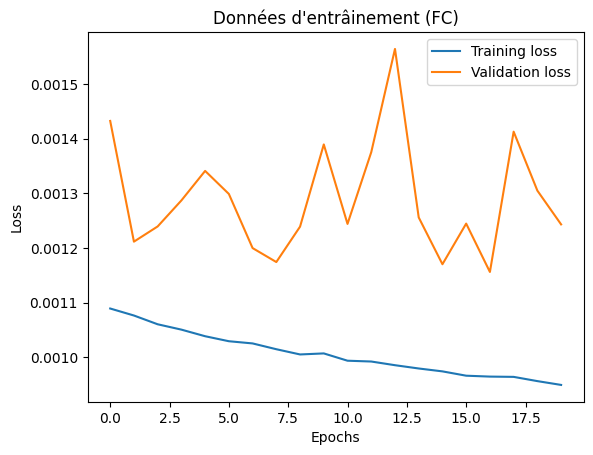

In [57]:
# Evaluer l'apprentissage d'un modèle --Code: Patrick Reuter--
def montrerCourbesApprentissage(history):
    #list all data in history
    print(history.history.keys())

    plt.plot(history.history['loss'][10:], label="Training loss")
    plt.plot(history.history['val_loss'][10:], label="Validation loss")

    plt.title("Données d'entrâinement (FC)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

montrerCourbesApprentissage(history)

# On enregistre le modèle

In [58]:
enco_save_path = os.path.join('modeles/', 'my_enco_model.keras')
encoder.save(enco_save_path)

deco_save_path = os.path.join('modeles/', 'my_deco_model.keras')
decoder_model.save(deco_save_path)

# On charge le modèle

In [22]:
enco_save_path = os.path.join('modeles/', 'my_enco_model.keras')
deco_save_path = os.path.join('modeles/', 'my_deco_model.keras')


encoder_model = keras.models.load_model(enco_save_path)
decoder_model = keras.models.load_model(deco_save_path)

# Prédicitions sur un pixel

In [ ]:
lum_index = 3
pixel_index = 0
light_direction =light_dirs[lum_index]

latent_vector = encoder_model.predict(reshaped_input)[pixel_index]  # (8,)

# Prédire pour une direction spécifique (par exemple view_light_train[0])
decoder_input = np.concatenate([latent_vector, light_direction])[np.newaxis, :]
predicted_rgb = decoder_model.predict(decoder_input)  # (1, 3)
print("Predicted RGB:", predicted_rgb, "Original", target_rgb_train[pixel_index, lum_index])

6329/6329 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted RGB: [[0.03386237 0.2571045  0.46035102]] Original [0.0627451  0.32156864 0.54901963]


# Génération de la carte latente

In [23]:
encoder_input_for_all_pixels = texel_observations # Shape: (num_pixels, 81, 3)

# L'encodeur prendra (num_pixels, 81, 3) et produira (num_pixels, latent_dim)
all_latent_vectors = encoder_model.predict(encoder_input_for_all_pixels, verbose=1)
latent_map = all_latent_vectors.reshape((img_height, img_width, latent_dim))
print(f"Forme de la carte latente: {latent_map.shape}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Forme de la carte latente: (50, 50, 8)


In [50]:
def show_comparaison(latent_map, choose_decoder_model, light_direction_2d, ground_truth_image):
    H, W, latent_dim = latent_map.shape
    num_pixels = H * W

    # Préparer l'entrée du décodeur pour tous les pixels
    latent_flat = latent_map.reshape(-1, latent_dim)  # (H*W, latent_dim)

    # Répéter la direction de lumière pour qu'elle corresponde à chaque pixel
    light_dir_repeated = np.repeat(light_direction_2d[np.newaxis, :], num_pixels, axis=0)

    # Concaténer le vecteur latent de chaque pixel avec la direction de lumière répétée
    decoder_input_combined = np.concatenate([latent_flat, light_dir_repeated], axis=1) # (H*W, latent_dim + angle_dim)


    # Prédiction par le décodeur
    predicted_rgb_flat = choose_decoder_model.predict(decoder_input_combined, verbose=0)  # (H*W, 3)
    predicted_image = predicted_rgb_flat.reshape(H, W, 3) # (H, W, 3)

    # Calcul de la différence absolue
    mse = np.mean(np.square(predicted_image - ground_truth_image))
    diff_image = np.abs(predicted_image - ground_truth_image)


    
    # Normalisation pour l'affichage et affichage
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    display_predicted = np.clip(predicted_image, 0, 1)
    display_ground_truth = np.clip(ground_truth_image, 0, 1)
    display_diff_image = np.clip(diff_image, 0, 1)
    
    # Affichage des images
    axs[0].imshow(display_predicted)
    axs[0].set_title("Image prédite")
    axs[0].axis('off')

    axs[1].imshow(display_ground_truth)
    axs[1].set_title("Image réelle")
    axs[1].axis('off')

    axs[2].imshow(display_diff_image)
    axs[2].set_title(f"Différence absolue (MSE: {mse:.5f})")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

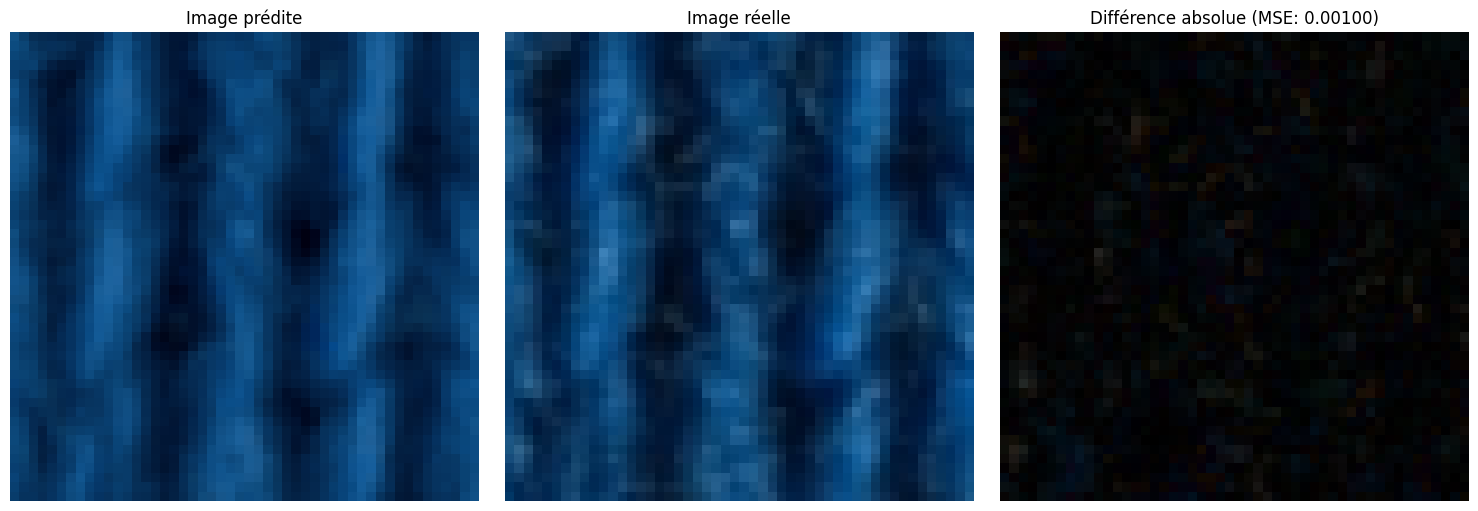

In [53]:
config = 80

angle_to_predict = light_dirs[config]
base_image = image_stack[config]

show_comparaison(latent_map, decoder_model, angle_to_predict, base_image)

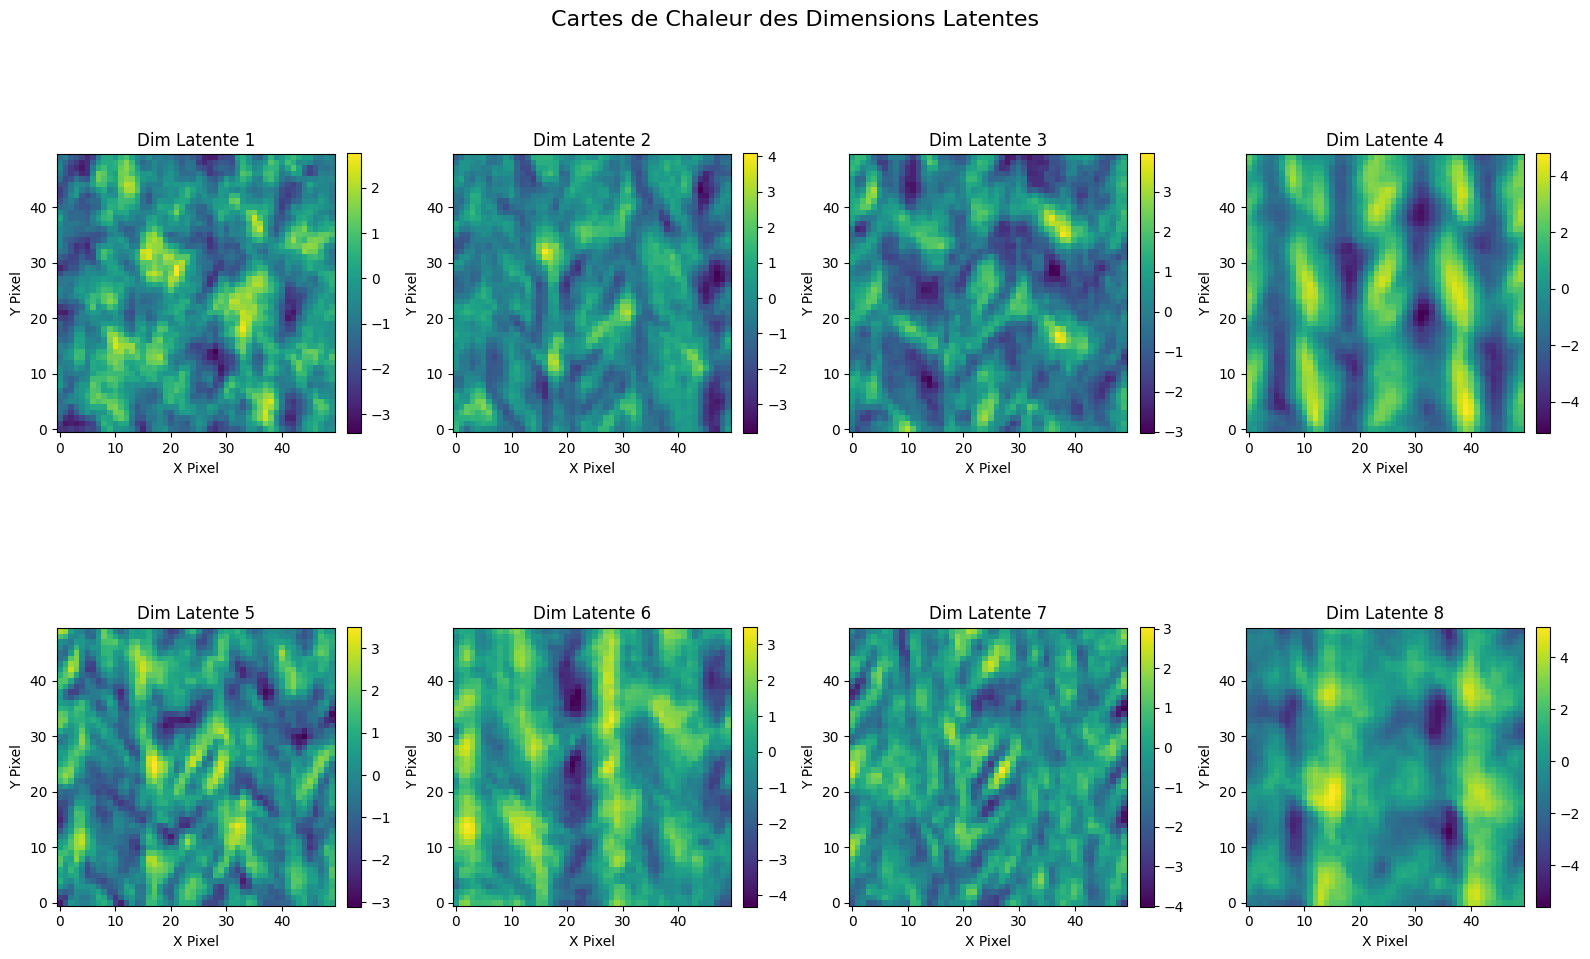

In [75]:
# HEAT MAP

ncols = 4

# Calcule le nombre de lignes nécessaires
nrows = (latent_dim + ncols - 1) // ncols # Division entière avec plafond

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 5 * nrows))

# Aplatir le tableau d'axes pour itérer facilement, quelle que soit la forme (1D ou 2D)
axes = axes.flatten()

for i in range(latent_dim):
    ax = axes[i]
    # Afficher la i-ème dimension latente comme une image 2D
    im = ax.imshow(latent_map[:, :, i], cmap='viridis', origin='lower')
    ax.set_title(f'Dim Latente {i+1}')
    ax.set_xlabel('X Pixel')
    ax.set_ylabel('Y Pixel')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04) # Ajuster la barre de couleur

# Masquer les subplots vides si latent_dim n'est pas un multiple de ncols
for j in range(latent_dim, len(axes)):
    fig.delaxes(axes[j]) # Supprime les axes vides

plt.tight_layout()
plt.suptitle('Cartes de Chaleur des Dimensions Latentes', y=1.02, fontsize=16) # y=1.02 pour laisser de la place au titre principal
plt.show()

## On peut essayer le TSNE

Forme des données pour t-SNE: (2500, 8)
Calcul de t-SNE...


/Users/sebych/miniforge3/envs/MLStuff/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE calculé en 6.51 secondes.
Forme des données après t-SNE: (2500, 2)


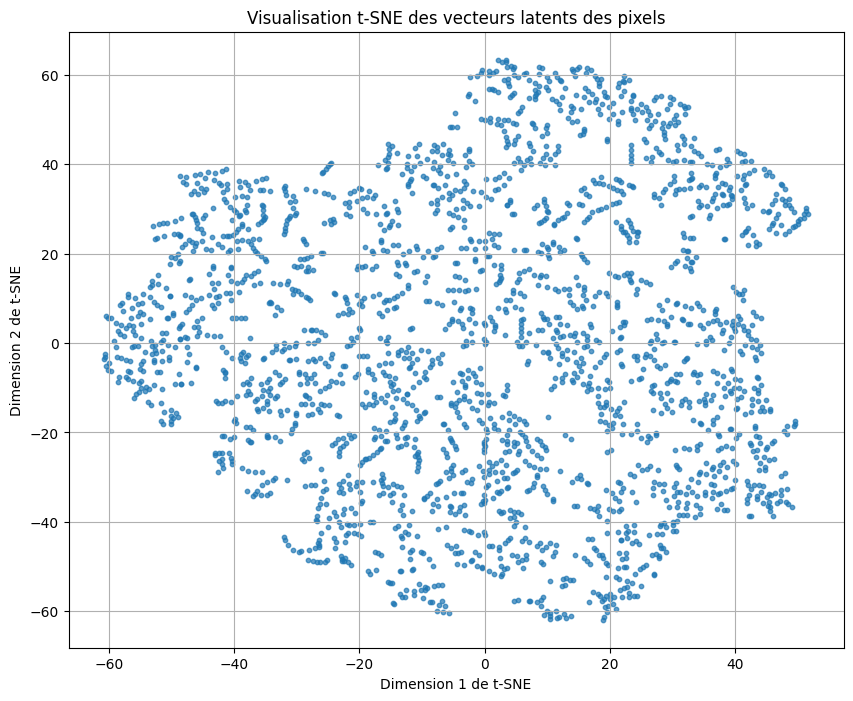

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time

H, W, latent_dim = latent_map.shape
num_pixels = H * W

# Aplatir la carte latente pour obtenir tous les vecteurs latents de pixels
latent_map.reshape(-1, latent_dim) #va transformer (H, W, latent_dim) en (H*W, latent_dim)
latent_vectors_flat = latent_map.reshape(num_pixels, latent_dim)

print(f"Forme des données pour t-SNE: {latent_vectors_flat.shape}")

# - n_components: la dimension de l'espace de sortie (généralement 2 pour la visualisation 2D)
# - perplexity: mesure l'équilibre entre l'attention portée aux voisins locaux et globaux (valeur typique entre 5 et 50)
# - n_iter: nombre maximum d'itérations
# - learning_rate: taux d'apprentissage de l'optimisation
# - random_state: pour la reproductibilité des résultats

print("Calcul de t-SNE...")
start_time = time.time()

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, learning_rate=200, random_state=42)

# Effectuer la réduction de dimensionnalité
# Le résultat 'latent_2d' aura la forme (num_pixels, 2)
latent_2d = tsne.fit_transform(latent_vectors_flat)

end_time = time.time()
print(f"t-SNE calculé en {end_time - start_time:.2f} secondes.")
print(f"Forme des données après t-SNE: {latent_2d.shape}")

# Visualisation des résultats t-SNE

plt.figure(figsize=(10, 8))

# Chaque point dans 'latent_2d' représente un pixel.
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], s=10, alpha=0.7) # 's' est la taille des points, 'alpha' est la transparence

plt.title("Visualisation t-SNE des vecteurs latents des pixels")
plt.xlabel("Dimension 1 de t-SNE")
plt.ylabel("Dimension 2 de t-SNE")
plt.grid(True)
plt.show()

Forme des données pour t-SNE: (2500, 8)
Calcul de t-SNE... Cela peut prendre un certain temps pour de grandes quantités de données.


/Users/sebych/miniforge3/envs/MLStuff/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE calculé en 6.17 secondes.
Forme des données après t-SNE: (2500, 2)


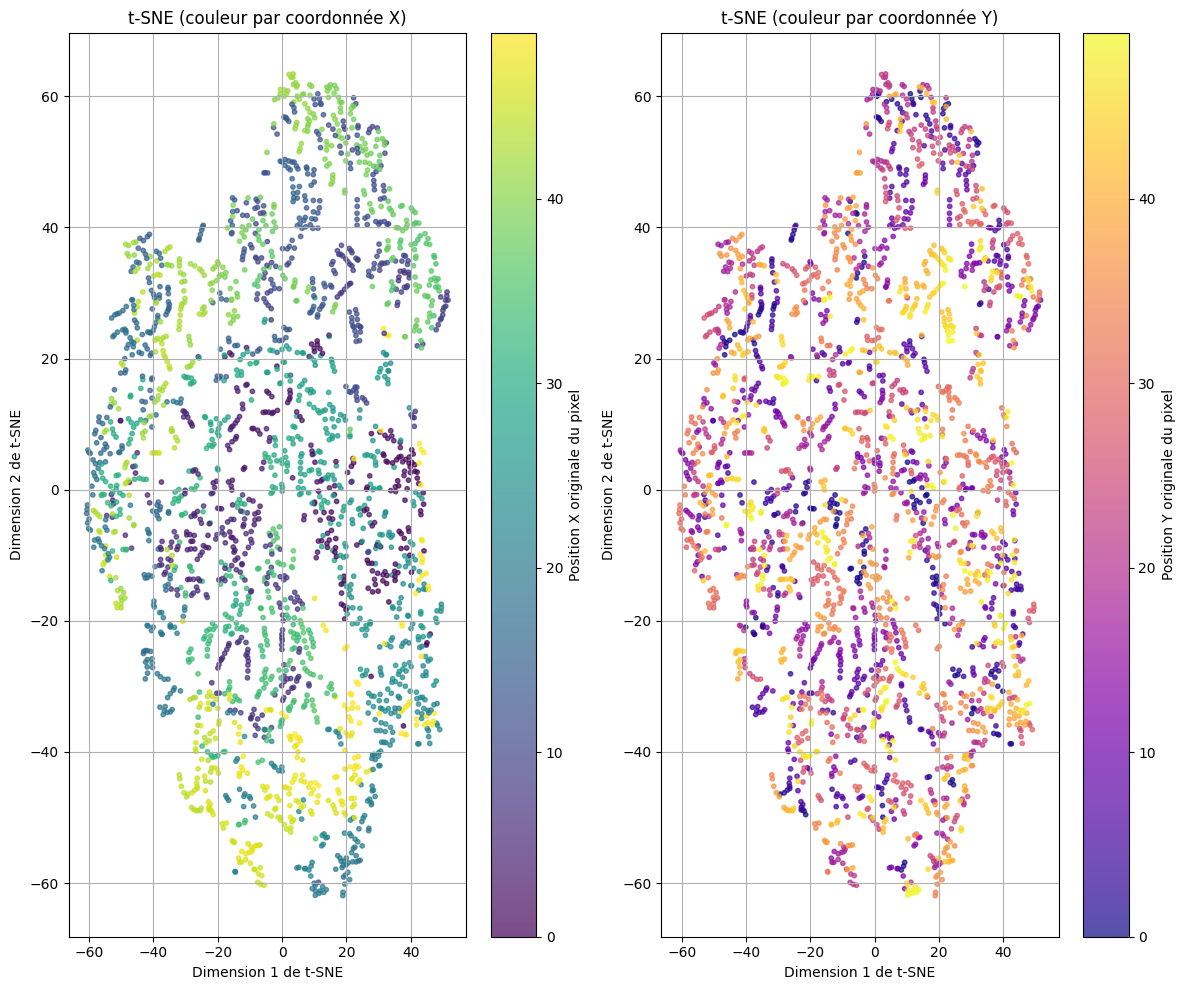

In [77]:
H, W, latent_dim = latent_map.shape
num_pixels = H * W

# Aplatir la carte latente pour obtenir tous les vecteurs latents de pixels
# latent_map.reshape(-1, latent_dim) va transformer (H, W, latent_dim) en (H*W, latent_dim)
latent_vectors_flat = latent_map.reshape(num_pixels, latent_dim)

print(f"Forme des données pour t-SNE: {latent_vectors_flat.shape}")

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, learning_rate=200, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors_flat)
print(f"Forme des données après t-SNE: {latent_2d.shape}")

# Visualisation des résultats t-SNE avec coloration par position du pixel

plt.figure(figsize=(12, 10))

# Générer les coordonnées X et Y pour chaque pixel de l'image originale
# même longueur que latent_2d (num_pixels)
x_coords_original = np.tile(np.arange(W), H) # Répète 0, 1, ..., W-1 H fois
y_coords_original = np.repeat(np.arange(H), W) # Répète chaque ligne (0, ..., H-1) W fois


# Colorer les points par leur position X dans l'image originale
plt.subplot(1, 2, 1) # Créer une sous-figure pour cette option
scatter1 = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=x_coords_original, cmap='viridis', s=10, alpha=0.7)
plt.colorbar(scatter1, label="Position X originale du pixel")
plt.title("t-SNE (couleur par coordonnée X)")
plt.xlabel("Dimension 1 de t-SNE")
plt.ylabel("Dimension 2 de t-SNE")
plt.grid(True)

# Colorer les points par leur position Y dans l'image originale
plt.subplot(1, 2, 2) # Créer une autre sous-figure
scatter2 = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=y_coords_original, cmap='plasma', s=10, alpha=0.7)
plt.colorbar(scatter2, label="Position Y originale du pixel")
plt.title("t-SNE (couleur par coordonnée Y)")
plt.xlabel("Dimension 1 de t-SNE")
plt.ylabel("Dimension 2 de t-SNE")
plt.grid(True)

plt.tight_layout() # Ajuster les sous-figures pour éviter les chevauchements
plt.show()